# Bands Structure

For the source code, see [bands](https://workgraph-collections.readthedocs.io/en/latest/ase/espresso/module.html#workgraph_collections.ase.espresso.bands.bands_workgraph).

## Example: Silicon

### Prepare the inputs and submit the workflow


In [1]:
from ase.build import bulk
from aiida import load_profile
from copy import deepcopy

from workgraph_collections.ase.espresso.bands import BandsWorkgraph
from aiida_pythonjob.config import config
# allow pickle
config["allow_pickle"] = True

load_profile()

atoms = bulk('Si')


metadata = {
    "options": {
        'prepend_text' : """eval "$(conda shell.posix hook)"
        conda activate aiida
        export OMP_NUM_THREADS=1
        """,
    }
}
pseudopotentials = {"Si": "Si.pbe-nl-rrkjus_psl.1.0.0.UPF"}
pseudo_dir = "/home/xing/data/ase/espresso_pseudo"
# pseudo_dir = "/home/wang_x3/datas/pseudos/psl"
scf_input_data = {
    "control": {"calculation": "scf",
                },
    "system": {"ecutwfc": 30, "ecutrho": 240,
               "occupations": "smearing",
                "degauss": 0.01,
                "smearing": "cold"
                },
}
relax_input_data = deepcopy(scf_input_data)
relax_input_data["control"].update({"calculation": "vc-relax"})
bands_input_data = deepcopy(scf_input_data)
bands_input_data["control"].update({"calculation": "bands"})

inputs = {
    "relax": {
        "input_data": relax_input_data,
        "kpts": [4, 4, 4],
        "computer": "localhost",
        "metadata": metadata
    },
    "scf": {
        "input_data": scf_input_data,
        "kpts": [4, 4, 4],
        "computer": "localhost",
        "metadata": metadata
    },
    "bands": {
        "input_data": bands_input_data,
        "computer": "localhost",
        "metadata": metadata
    },
}
#------------------------- Set the inputs -------------------------
wg = BandsWorkgraph.build_graph(atoms=atoms,
                    pw_command="mpirun -np 1 pw.x",
                    pseudopotentials=pseudopotentials,
                    pseudo_dir=pseudo_dir,
                    inputs=inputs,
                    density=10,
                    run_relax=True,
                    run_scf=True,
                    )
wg.to_html()

Run the workgraph:

In [2]:
wg.run()

09/03/2025 09:32:44 PM <374217> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [178886|WorkGraphEngine|continue_workgraph]: tasks ready to run: pw_calculator
REPORT:aiida.orm.nodes.process.workflow.workchain.WorkChainNode:[178886|WorkGraphEngine|continue_workgraph]: tasks ready to run: pw_calculator
09/03/2025 09:32:45 PM <374217> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [178886|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 178890
REPORT:aiida.orm.nodes.process.workflow.workchain.WorkChainNode:[178886|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 178890
09/03/2025 09:33:04 PM <374217> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [178886|WorkGraphEngine|update_task_state]: Task: pw_calculator, type: PYTHONJOB, finished.
REPORT:aiida.orm.nodes.process.workflow.workchain.WorkChainNode:[178886|WorkGraphEngine|update_task_state]: Task: pw_calculator, type: PYTHONJOB, finishe

## Plot the band structure

<Axes: ylabel='energies [eV]'>

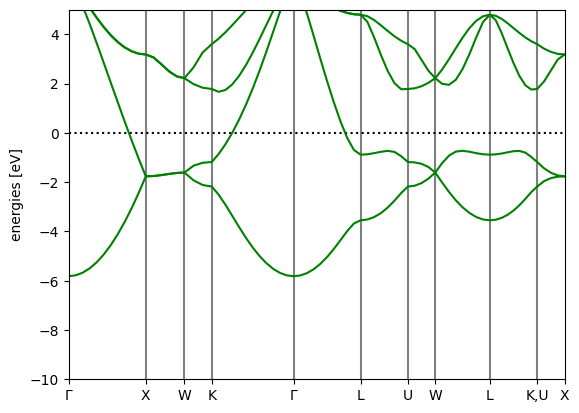

In [3]:
from ase.spectrum.band_structure import BandStructure
import numpy as np

data = wg.outputs.bands.band.value.value
eigenvalues = np.array([np.array(data['bands']['energies'])])
kpts = wg.outputs.kpoints_path.value.value
bs = BandStructure(path=kpts, energies=eigenvalues)
bs.plot()